## Не изменяйте данный файл! Его функция - описать блоки кода и возможности этого скрипта, а также показать решения возможных часто встречающихся проблем. Для генерации графиков для конкретного НТ создайте скрипт на основе этого.
Все данные о конкретном тестовом прогоне вносятся во второй блок. Внимательно читайте инструкции по заполнению ниже.

### Переменные, их назначение и особенности заполнения
* TOKEN - токен для доступа к Zabbix API. У нас есть непротухающий токен, но если по какой-то причине нужно будет взять новый, поставить TOKEN = None и указать логин/пароль в переменных ниже.
* ZABBIX_LOGIN - оставить None, если в TOKEN есть непротухающий токен.
* ZABBIX_PASSWORD - оставить None, если в TOKEN есть непротухающий токен.

* HOST_ID - ID тестируемого стенда. Можно взять из адресной строки при просмотре графиков на Zabbix UI (значение параметра "filter_hostids[0]").

* INDICATOR_NAME - название отслеживаемого показателя. Можно использовать название графика, если на графике на Zabbix UI отображается только один показатель (например, `Memory utilization` у `goodt-loadqa-db`). Если график сборный, как, например, `WFM CPU Usage` у `pochta-release-qa`, то нужно указать название одного из показателей на графике, например, `Cpu_back_usage`.
* SCENARIO_NAME - название пройденного сценария, используется в названии графика.

* TEST_START_TIME - время начала тестирования (по UTC) в формате 'YYYY-MM-DD HH:MM:SS'.
* TEST_END_TIME - время окончания тестирования (по UTC) в формате 'YYYY-MM-DD HH:MM:SS'.
* TIME_UNIT - единица измерения времени. Определяет величину, в которой будет измеряться время на шкале X на графиках и в переменной DELIMITERS.
* DELIMITERS - список временных отметок для разделения этапов подачи нагрузки.

* IMG_PATH - название папки, в которую складываются итоговые графики.
* IMG_PREFIX - префикс, добавляемый к генерируемым графикам.

> Примечание: вполне вероятно, что при отрисовке графиков для конкретных прогонов не удаствся получить красивую картинку со значениями параметров по умолчанию. В этом случае обратитесь к документации функции graph: там довольно много настроек, которые позволяют обрезать и кастомизировать внешний вид графика.

In [2]:
import calendar
import time
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import requests
from enum import Enum

In [3]:
# Глобальные переменные, их менять не нужно

BASE_URL = 'https://monitor.goodt.me:8443/api_jsonrpc.php'
HEADER = {'Content-type': 'application/json'}
NAME = 'name'
VALUE = 'value'
CLOCK = 'clock'
RESULT = 'result'


class TimeUnit(Enum):
    MILLISECONDS = "мс", 0.001,
    SECONDS = "с", 1,
    MINUTES = "мин", 60,
    HOURS = "ч", 60 * 60

    def __init__(self, symbol: str, divider: int) -> None:
        self.symbol = symbol
        self.divider = divider

In [4]:
# Глобальные переменные, их менять можно/нужно

TOKEN = "0a612a0e3251be683bb0020233e72224acf8a6bb00723f846b26a6ad1601d544"
ZABBIX_LOGIN = None
ZABBIX_PASSWORD = None

HOST_ID = 11908
INDICATOR_NAME = 'Cpu_backend_usage'
SCENARIO_NAME = 'pochta'

TEST_START_TIME = '2022-12-15 06:00:00'
TEST_END_TIME = '2022-12-15 07:00:00'
TIME_UNIT = TimeUnit.MINUTES
DELIMITERS = [10, 50]

IMG_PATH = 'img'
IMG_PREFIX = 'z_'

In [5]:
# Данный блок работает с API

def get_api_token():
    """
    Получает токен авторизации.
    В данный момент функция не используется, т.к. есть токен без срока окончания действия.
    Но если возникнет необходимость получить новый, то можно воспользоваться этой функцией.
    :return:
    """
    auth_param = {
        "user": ZABBIX_LOGIN,
        "password": ZABBIX_PASSWORD
    }
    auth_body = {
        "jsonrpc": "2.0",
        "method": "user.login",
        "params": auth_param,
        "id": 1
    }
    global TOKEN
    TOKEN = requests.post(BASE_URL, json=auth_body, headers=HEADER).json()['result']
    
def send_request(json):
    """
    Отправляет указанный json в API и возвращает тело ответа.
    """
    if not TOKEN:
        get_api_token()
    response = requests.post(BASE_URL, json=json, headers=HEADER)
    if response.status_code != 200:
        raise AssertionError(f"Не удалось получить данные от сервера. Код ответа {response.status_code}")
    return response.json()

In [6]:
# Данный блок формирует тела для запросов, использующихся для составления графика

def assemble_request_json_for_indicator_values(item_id, from_t, to_t, history_type=0):
    """
    Возвращает json для отправки запроса на получение данных для построения графика нужного показателя.
    :param item_id: идентификатор показателя (например, утилизация ЦПУ);
    :param from_t: время начала замера;
    :param to_t: время окончания замера;
    :param history_type: тип данных. В большинстве случае можно оставить значение по умолчанию.
    Подробнее: https://www.zabbix.com/documentation/current/en/manual/api/reference/history/get
    """
    params_cpu = {"output": "extend",
                  "history": history_type,
                  "itemids": item_id,
                  "sortfield": "clock",
                  "sortorder": "DESC",
                  "time_from": from_t,
                  "time_till": to_t,
                  "limit": 1000}
    json_to_send = {
        "jsonrpc": "2.0",
        "method": "history.get",
        "id": 2,
        "auth": TOKEN,
        "params": params_cpu}
    return json_to_send


def assemble_request_json_for_indicator_id(host_id):
    """
    Возвращает json для отправки запроса на получение данных о показателях, отслеживаемых на стенде с заданным id.
    :param host_id: id стенда
    """
    return {
        "jsonrpc": "2.0",
        "method": "item.get",
        "params": {
            "output": "extend",
            "hostids": host_id,
            "sortfield": "name"
        },
        "auth": TOKEN,
        "id": 1
    }

In [7]:
# Данный блок обрабатывает и возвращает данные, полученные из Zabbix API

def get_indicator_id_by_name(indicator_name):
    """
    Делает запрос в API и возвращает id искомого показателя мониторинга.
    :param indicator_name: название индикатора. Должно совпадать с названием графика, указанным на UI Zabbix.
    """
    body = send_request(assemble_request_json_for_indicator_id(HOST_ID))
    indicators = body[RESULT]
    for indicator in indicators:
        if indicator[NAME] == indicator_name:
            return indicator['itemid'], indicator['units']
    raise ValueError(f'Не найден идентификатор показателя под названием {indicator_name}. '
                     f'Название показателя должно совпадать с названием графика, указанным на UI Zabbix.')


def get_indicator_dataframe(indicator_name=INDICATOR_NAME):
    """
    Делает запрос в API и возвращает DataFrame с полученными данными.
    :param indicator_name: название показателя.
    """
    indicator_id, units = get_indicator_id_by_name(indicator_name)
    start_common = calendar.timegm(time.strptime(TEST_START_TIME, '%Y-%m-%d %H:%M:%S'))
    end_common = calendar.timegm(time.strptime(TEST_END_TIME, '%Y-%m-%d %H:%M:%S'))

    body = send_request(assemble_request_json_for_indicator_values(indicator_id,
                                                                   start_common,
                                                                   end_common))
    if not body[RESULT]:
        raise AssertionError("Список в поле \"result\" пуст. Проверьте правильность введенного времени и HOST_ID.")
    df = pd.DataFrame(body[RESULT])
    df = df.astype({CLOCK: int, VALUE: float})
    df = df.sort_values(by=CLOCK)
    min_clock = df[CLOCK].min()
    df[CLOCK] = df[CLOCK] - min_clock
    return df, units

In [8]:
def graph(tp,
          *delimiters,
          graph_title=f"{SCENARIO_NAME}, {INDICATOR_NAME}",
          x_tick=10,
          y_tick=10,
          top_margin=1,
          x_axis_label="Время от начала теста",
          time_unit=TIME_UNIT,
          y_axis_format="%.2f"):
    """
    Строит график
    :param units: единицы измерения по шкале Y
    :param time_unit: единица измерения времени на оси X. По умолчанию берет значение глобальной переменной TIME_UNIT
    :param graph_title: название графика;
    :param tp: dataframe с данными мониторинга и единица измерения по шкале Y;
    :param delimiters: x-координаты вертикальных линий для разграничения этапов НТ_скрипта;
    :param x_tick: деления по оси x;
    :param y_tick: деления по оси y;
    :param top_margin: размер отступа в верхней части диаграммы;
    :param x_axis_label: подпись графика по оси X;
    :param y_axis_format: формат для вывода подписей по оси Y;
    """
    color = '#000000'
    ax, fig = plt.subplots(figsize=(80, 30))
    data_frame = tp[0]
    plt.xticks(np.arange(0, data_frame[CLOCK].max() / time_unit.divider, x_tick), size=50)
    plt.yticks(np.arange(0, data_frame[VALUE].max() + top_margin, y_tick), size=50)
    plt.plot(data_frame[CLOCK] / time_unit.divider, data_frame[VALUE])
    plt.title(graph_title, fontsize=80)
    for delimiter in delimiters:
        plt.axvline(x=delimiter, color=color)
    plt.xlabel(x_axis_label + ", " + time_unit.symbol, fontsize=60)
    plt.ylabel(tp[1], fontsize=60)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(y_axis_format))
    plt.legend()
    plt.grid()
    if not os.path.exists(IMG_PATH):
        os.mkdir(IMG_PATH)

    plt.savefig(IMG_PATH + '/' + IMG_PREFIX + graph_title + '.jpg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


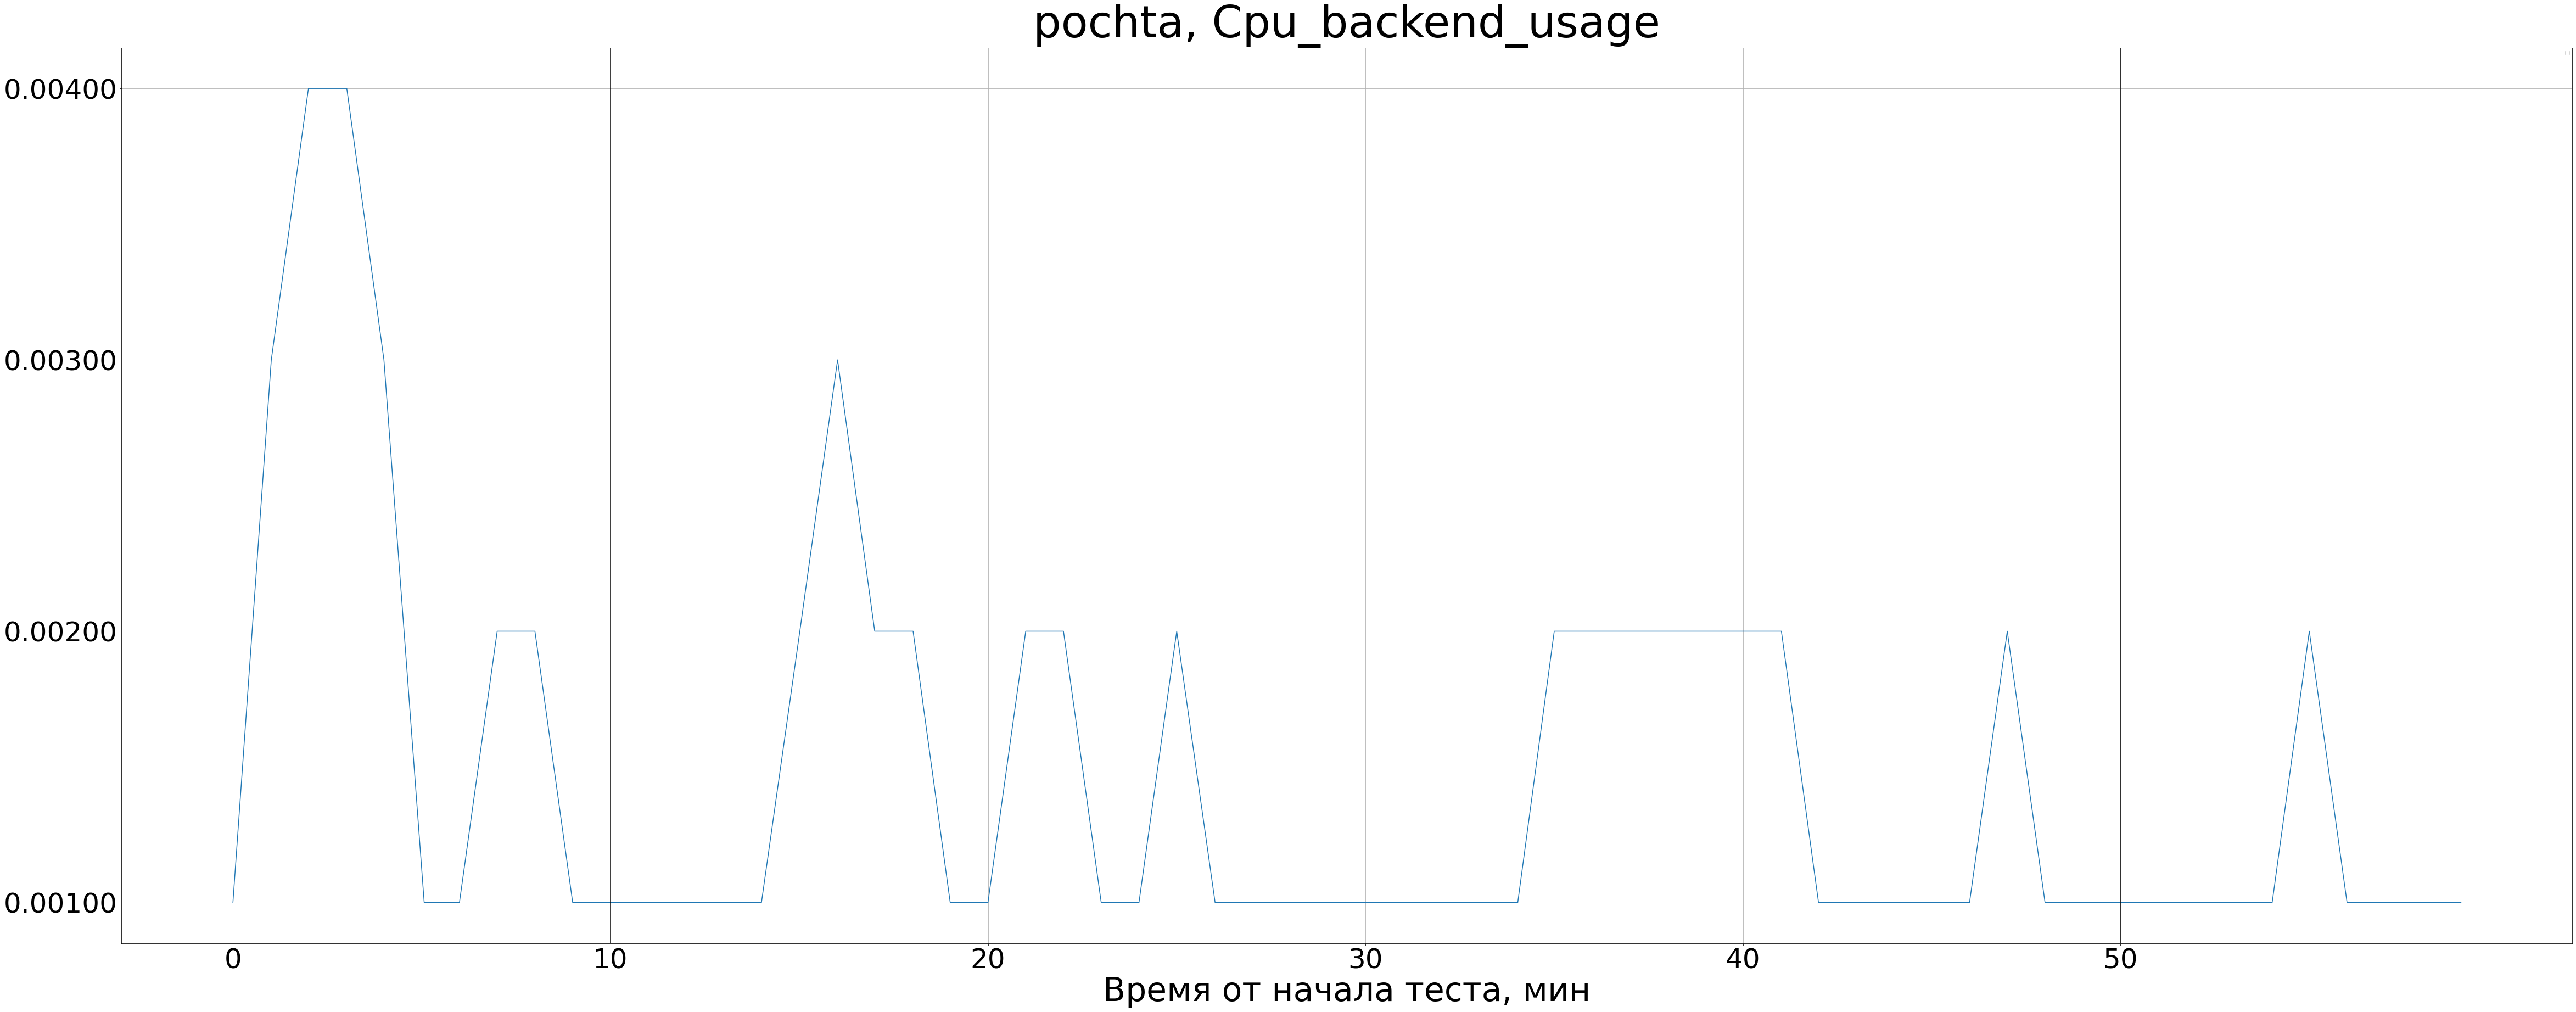

In [12]:
# Пример построения графика

graph(get_indicator_dataframe(),
    y_tick=0.001,
    y_axis_format='%.3f',
    *DELIMITERS)

In [ ]:
# Пример построения дополнительного графика

indicator = "Memory_calculation_usage"
graph(get_indicator_dataframe(indicator),
    graph_title=f"{SCENARIO_NAME}, {indicator}",
    y_tick=10000,
    y_axis_format='%.0f',
    *DELIMITERS)